# Essais avec les données du Allen Institute

## Exemple type d'expérience
* __Analyse 1__
    1. Choisir une région du cerveau à étudier.

    2. Recupérer les expériences du Allen pour lesquelles il y a beaucoup de fluorescence à cet endroit. 

    3. Télécharger les volumes du Allen correpondants

    4. Aligner sur nos cerveaux de référence

    5. Intégrer ces volumes au SBH-Assistant (pour aider les utilisateurs du microscope à cibler les régions où on s'attend à avoir beaucoup de signal.)

* __Analyse 2__ 
    1. Proposer des lieux d'injections
    
    2. Obtenir du signal dans notre région ciblée. 

# Mouse Connectivity Cache

## Recherche par liste de régions d'injection (cache)

In [ ]:
# exemple sur les injections à l'isocortex
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()

structure_tree = mcc.get_structure_tree()
isocortex_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']                             
injection_regions_ids = [isocortex_id]

experiments = mcc.get_experiments(dataframe=True, injection_structure_ids=injection_regions_ids)
print("%d total experiments" % len(experiments))

experiments

## Recherche par coordonnées d'injection (cache)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

def load_allen_experiments():
    # open up a list of all of the experiments
    return MouseConnectivityCache().get_experiments(dataframe=True)

def get_id_from_injection_coord(injection_coord):#(x,y,z):
    #injection_coord = [x, y, z]
    all_experiments = load_allen_experiments()
    experiment_id = all_experiments.index[all_experiments['injection-coordinates'].map(set(injection_coord).issubset)].tolist() 
    return experiment_id[0]

def get_projection_density(experiment_id):
    pd, pd_info = mcc.get_projection_density(experiment_id)
    # compute the maximum intensity projection (along the anterior-posterior axis) of the projection data
    pd_mip_x = pd.max(axis=0)
    pd_mip_y = pd.max(axis=1)
    f, pr_axes = plt.subplots(1, 2, figsize=(15, 6))
    pr_axes[0].imshow(pd_mip_x, cmap='hot', aspect='equal')
    pr_axes[0].set_title("projection density MaxIP")
    pr_axes[1].imshow(pd_mip_y, cmap='hot', aspect='equal')
    pr_axes[1].set_title("projection density MaxIP")
    plt.show()
    return

load_allen_experiments()
experiment_id = get_id_from_injection_coord([5520, 4470, 10080])
get_projection_density(experiment_id)

## Toutes les experiences (tous les ids)

In [37]:
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from pathlib import Path
import os
import glob

id = 636021145
ids = MouseConnectivityCache().get_experiments(dataframe=True).id

if id not in ids: print('not in id')
else: print("in ids")

os.remove('./experiments.json')
os.remove('./mouse_connectivity_manifest.json')


not in id


## Liste des régions du cerveau

In [ ]:
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

structure_tree = MouseConnectivityCache().get_structure_tree()
summary_structures =  structure_tree.get_structures_by_set_id([167587189])
pd.DataFrame(summary_structures)#[['acronym','name','id']]

# Mouse Connectivity API

## Experiment details

In [ ]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

roi = pd.DataFrame(mca.get_experiment_detail(288169135)).specimen[0]['stereotaxic_injections'][0]['primary_injection_structure']['acronym']
print(roi)

mca.get_experiment_detail(288169135)

# Left or Right injection centroid

In [79]:
def loc_injection_centroid(args):
    """
    Localize the position (Left or Right) of the injection centroid in the Mouse Brain.
    A resolution of 100µm is used to minimize downloading time.

    Parameters
    ----------
    args: argparse namespace
        Argument list.

    Return
    ------
    string : R or L
    """
    # Creating tmp files
    path_fraction = f"./utils/tmp/{args.id}_inj_fraction.nrrd"
    path_density =  f"./utils/tmp/{args.id}_density.nrrd"

    # Downloading the injection fraction and density of the experiment
    injection_density = mca.download_injection_density(path_density,
                                                       experiment_id=args.id, resolution=100)
    injection_fraction = mca.download_injection_fraction(path_fraction,
                                                         experiment_id=args.id, resolution=100)

    # Loading the volumes
    dens_vol, header = nrrd.read(path_density)
    frac_vol, header = nrrd.read(path_fraction)

    # Removing tmp files
    os.remove(path_density)
    os.remove(path_fraction)

    # Downloading the injection centroid
    injection_centroid = mca.calculate_injection_centroid(injection_density=dens_vol,
                                                          injection_fraction=frac_vol)
    
    # Defining the Left-Right limit (+z axis)
    # Note: the bounding box is [2640, 1600, 2280]
    limit_LR =  1140/2

    # Returning the position
    if injection_centroid[2] >= limit_LR:
        return 'R'
    else:
        return 'L'

In [180]:
import nrrd
import numpy as np
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

id = 288169135
#id = 603468246
pathf = '../../niftis/fraction.nrrd'
pathd =  '../../niftis/density.nrrd'
res = 100
injection_density = mca.download_injection_density(
    pathd,
    experiment_id=id,
    resolution=res
)

dens_vol, header = nrrd.read(pathd)

injection_fraction = mca.download_injection_fraction(
    pathf,
    experiment_id=id,
    resolution=res
)

frac_vol, header = nrrd.read(pathf)

injection_centroid = mca.calculate_injection_centroid(
    injection_density=dens_vol, 
    injection_fraction=frac_vol,
    resolution=res
    )

os.remove(pathd)
os.remove(pathf)

print(injection_centroid)

#25  -> bb 10µm 11400/2 > R
#50  -> bb 25µm 4560/2 > R
#100 -> bb 50µm 2280/2 > R

if injection_centroid[2] > 1140/2:
    print('R')
else:
    print('L')

2022-06-01 11:09:19,901 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288169135?image=injection_density&resolution=100
2022-06-01 11:09:20,463 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288169135?image=injection_fraction&resolution=100


[4457.64569365 1658.49099857 7098.5526801 ]
R


In [2]:
import numpy as np
import pandas as pd
import allensdk
import nibabel as nib
import ants

## Tests allers-retours mi brain allen

* identifer une coordonnée dans mi-brain
    * mm, voxel
* transformer cette coordonnée en Allen
    * voxel, micron
* faire une inj_coord_search ou spacial_search

# ants

### mi brain mm <-> voxels

In [12]:
def mibrain_voxel2mm_RAS(coords_voxel):
    x, y, z = coords_voxel[0], coords_voxel[1], coords_voxel[2]
    B = np.array([[-0.07,  0,        0,      5.675  ],
                 [  0,    -0.07,     0,      8.79448],
                 [  0,     0,        0.07,  -8.40533],
                 [  0,     0,        0,      1      ]])

    coords_voxel = np.array([x, y, z, 1])
    coords_mm = B @ coords_voxel

    return coords_mm, B

mibrain_mm, B = mibrain_voxel2mm_RAS([102,126,117.4])
print(mibrain_mm)

mibrain_voxel = np.linalg.inv(B) @ mibrain_mm
print(mibrain_voxel)

# reobtenir les mm
print(B @ [102,126,117.4,1])


[-1.465   -0.02552 -0.18733  1.     ]
[102.  126.  117.4   1. ]
[-1.465   -0.02552 -0.18733  1.     ]


### allen µm <-> allen voxel  <=> mi brain voxel

In [3]:
import ants

In [4]:
tx25 = ants.read_transform('/Users/mahdi/stage-2022-mahdi/utils/transformations_allen2avgt/allen2avgtAffine_25.mat')
itx25 = tx25.invert()

def pir_ras(coords, pir):
    p, i, r = pir[0], pir[1], pir[2]
    x, y, z = coords[0], coords[1], coords[2]
    x_, y_, z_ = z, p-x, i-y
    return [x_, y_, z_]

def ras_pir_25(coords, ras):
    r, a, s = ras[2], ras[0], ras[1]
    x, y, z = coords[0], coords[1], coords[2]
    x_, y_, z_ = a-y, s-z, x
    return [x_*25, y_*25, z_*25]

allen_ras = pir_ras([4240/25, 1700/25, 7150/25], (528,320,456))
mibrain = itx25.apply_to_point(allen_ras)
print(mibrain)
print(list(map(int, mibrain)))

allen_ras = tx25.apply_to_point(mibrain)
print(allen_ras)
allen_pir = ras_pir_25(allen_ras, (528,320,456))
print(allen_pir)
print(list(map(int, allen_pir)))

(102.147705078125, 129.98590087890625, 118.84606170654297)
[102, 129, 118]
(286.0000915527344, 358.4000244140625, 252.0)
[4239.9993896484375, 1700.0, 7150.002288818359]
[4239, 1700, 7150]


#### test sur une region prise dans mibrain où il y a de la fluo 

In [5]:
mibrain_voxel_coords = [66, 136, 100]
allen_voxel_ras_coords = tx25.apply_to_point(mibrain_voxel_coords)
print(allen_voxel_ras_coords)
allen_um_pir = ras_pir_25(allen_voxel_ras_coords, (528,320,456))
print(allen_um_pir)
allen_um_int = list(map(int, allen_um_pir))
print(allen_um_int)

(184.77590942382812, 361.71539306640625, 196.5880126953125)
[4157.115173339844, 3085.2996826171875, 4619.397735595703]
[4157, 3085, 4619]


In [254]:
mibrain_voxel_coords = [0, 212, 158]
allen_voxel_ras_coords = tx25.apply_to_point(mibrain_voxel_coords)
print(allen_voxel_ras_coords)
allen_um_pir = ras_pir_25(allen_voxel_ras_coords, (528,320,456))
print(allen_um_pir)
allen_um_int = list(map(int, allen_um_pir))
print(allen_um_int)

(-0.1170884221792221, 607.9812622070312, 301.45843505859375)
[-1999.5315551757812, 463.53912353515625, -2.9272105544805527]
[-1999, 463, -2]


### #spatial

In [7]:
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

In [9]:
import pandas as pd

In [10]:
exp_list = MouseConnectivityApi().experiment_spatial_search(seed_point=[4157, 3085, 4619])
pd.DataFrame(exp_list)[['id','injection-coordinates','structure-name','structure-abbrev']].head()

id injection-coordinates                        structure-name  \
0  598604288    [3510, 2210, 7700]                  Secondary motor area   
1  127089669    [9070, 2210, 9650]                       Postrhinal area   
2  299783689    [4420, 4070, 9060]   Agranular insular area, dorsal part   
3  639813139    [3230, 2670, 4230]                  Secondary motor area   
4  477435412    [4300, 2010, 5380]  Anterior cingulate area, dorsal part   

  structure-abbrev  
0              MOs  
1           VISpor  
2              AId  
3              MOs  
4             ACAd

In [11]:
exp_list = MouseConnectivityApi().experiment_spatial_search(seed_point=[6890, 4990, 5550])
pd.DataFrame(exp_list)[['id','injection-coordinates','structure-name','structure-abbrev']].head()

id injection-coordinates  \
0  277854208    [6640, 6420, 6330]   
1  146078721    [8820, 1670, 7460]   
2  175106053    [6350, 5600, 5640]   
3  127089669    [9070, 2210, 9650]   
4  300923916    [6760, 5530, 6140]   

                                      structure-name structure-abbrev  
0                  Ventromedial hypothalamic nucleus              VMH  
1                 Superior colliculus, motor related              SCm  
2                      Anterior hypothalamic nucleus              AHN  
3                                    Postrhinal area           VISpor  
4  Paraventricular hypothalamic nucleus, descendi...             PVHd

In [12]:
exp_list = MouseConnectivityApi().experiment_spatial_search(seed_point=[3760, 2320, 6960])
pd.DataFrame(exp_list)[['id','injection-coordinates','structure-name','structure-abbrev']].head()

id injection-coordinates                       structure-name  \
0  598604288    [3510, 2210, 7700]                 Secondary motor area   
1  299783689    [4420, 4070, 9060]  Agranular insular area, dorsal part   
2  175019536    [6890, 4990, 5550]                  Nucleus of reuniens   
3  301583889    [5630, 2320, 8650]     Primary somatosensory area, nose   
4  639813139    [3230, 2670, 4230]                 Secondary motor area   

  structure-abbrev  
0              MOs  
1              AId  
2               RE  
3            SSp-n  
4              MOs

### #injection

In [5]:
exp_list = MouseConnectivityApi().experiment_injection_coordinate_search(seed_point=[4200, 1670, 7070])
pd.DataFrame(exp_list)[['id','distance','injection-coordinates','structure-name','structure-abbrev']].head()

id    distance injection-coordinates        structure-name  \
0  288169135    0.000000    [4200, 1670, 7070]    Primary motor area   
1  298273313   94.339811    [4240, 1700, 7150]    Primary motor area   
2  477836675  151.657509    [4170, 1620, 7210]    Primary motor area   
3  265929196  184.932420    [4090, 1570, 7180]  Secondary motor area   
4  298718072  334.664011    [4000, 1790, 7310]  Secondary motor area   

  structure-abbrev  
0              MOp  
1              MOp  
2              MOp  
3              MOs  
4              MOs

In [6]:
exp_list = MouseConnectivityApi().experiment_injection_coordinate_search(seed_point=[4240, 1700, 7150])
pd.DataFrame(exp_list)[['id','distance','injection-coordinates','structure-name','structure-abbrev']].head()

id    distance injection-coordinates        structure-name  \
0  298273313    0.000000    [4240, 1700, 7150]    Primary motor area   
1  288169135   94.339811    [4200, 1670, 7070]    Primary motor area   
2  477836675  122.065556    [4170, 1620, 7210]    Primary motor area   
3  265929196  200.748599    [4090, 1570, 7180]  Secondary motor area   
4  183103805  298.831056    [4060, 1830, 7350]    Primary motor area   

  structure-abbrev  
0              MOp  
1              MOp  
2              MOp  
3              MOs  
4              MOp

In [ ]:
exp_list = MouseConnectivityApi().experiment_injection_coordinate_search(seed_point=[4200, 1670, 7070])
pd.DataFrame(exp_list)[['id','distance','injection-coordinates','structure-name','structure-abbrev']].head()

id    distance injection-coordinates        structure-name  \
0  288169135    0.000000    [4200, 1670, 7070]    Primary motor area   
1  298273313   94.339811    [4240, 1700, 7150]    Primary motor area   
2  477836675  151.657509    [4170, 1620, 7210]    Primary motor area   
3  265929196  184.932420    [4090, 1570, 7180]  Secondary motor area   
4  298718072  334.664011    [4000, 1790, 7310]  Secondary motor area   

  structure-abbrev  
0              MOp  
1              MOp  
2              MOp  
3              MOs  
4              MOs

# Manuel 

In [59]:
def RAS_to_PIR_coords(ras_coord, pir_shape, ras_shape):
    # max len of RAS+ axis
    r_, a, s = ras_shape[0], ras_shape[1], ras_shape[2]
    
    # max len of PIR axis
    p, i, r = pir_shape[0], pir_shape[1], pir_shape[2]

    # scaling factors
    sx, sy, sz = p/a, i/s, r/r_

    # input PIR coordinates
    x, y, z = ras_coord[0], ras_coord[1], ras_coord[2]

    # outputs RAS+ coordinates
    x_ = (a-y) * sx
    y_ = (s-z) * sy 
    z_ = x * sz
    
    return (x_, y_, z_)
    
allen_coords_um = [4457.64569365, 1658.49099857, 7098.5526801]
bbox_allen = (132, 80, 114) #100µm par voxel
bbox_avgt = (164, 212, 158)

allen_voxel = RAS_to_PIR_coords(
    ras_coord=mibrain_voxel,
    pir_shape=bbox_allen,
    ras_shape=bbox_avgt)
print(allen_voxel)

allen_micron = [int(allen_voxel[0]*100), int(allen_voxel[1]*100), int(allen_voxel[2]*100)]
print(allen_micron)

(53.54716981132075, 20.556962025316448, 70.90243902439023)
[5354, 2055, 7090]


In [ ]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

injection_coordinates = allen_micron

nearby_experiment = pd.DataFrame(mca.experiment_injection_coordinate_search(seed_point=injection_coordinates))

nearby_experiment[['id','distance','injection-coordinates','structure-name','structure-abbrev']].head()

# masque unionize
* chercher la region où fluo > seuil pour les exp combinées
* prendre ids des structures
* download mask

In [13]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

stree = MouseConnectivityCache().get_structure_tree()

mc_structs = stree.get_structures_by_set_id([167587189])
mc_struct_ids = pd.DataFrame(mc_structs).id.tolist()
mc_struct_abrev = pd.DataFrame(mc_structs).acronym.tolist()

In [14]:
print(mc_struct_ids)
print(mc_struct_abrev)

[184, 985, 993, 353, 329, 337, 345, 369, 361, 182305689, 378, 1057, 677, 1011, 1002, 1027, 1018, 402, 394, 409, 385, 425, 533, 312782574, 312782628, 39, 48, 972, 44, 723, 731, 746, 104, 111, 119, 894, 879, 886, 312782546, 417, 541, 922, 895, 507, 151, 159, 589, 814, 961, 619, 639, 647, 788, 566, 382, 423, 463, 726, 982, 19, 918, 926, 843, 1037, 1084, 502, 484682470, 589508447, 484682508, 583, 952, 966, 131, 295, 319, 780, 672, 56, 998, 754, 250, 258, 266, 310, 333, 23, 292, 536, 1105, 403, 1022, 1031, 342, 298, 564, 596, 581, 351, 287, 629, 685, 718, 725, 733, 741, 563807435, 414, 422, 609, 1044, 475, 170, 218, 1020, 1029, 325, 255, 127, 64, 1120, 1113, 155, 59, 362, 366, 1077, 149, 15, 181, 560581559, 189, 599, 907, 575, 930, 560581563, 262, 27, 563807439, 178, 321, 483, 186, 390, 332, 38, 30, 118, 223, 72, 263, 272, 830, 452, 523, 763, 914, 1109, 126, 133, 347, 286, 338, 576073699, 689, 88, 210, 491, 525, 1126, 1, 515, 980, 1004, 63, 693, 946, 194, 226, 356, 364, 576073704, 173, 470,

In [15]:
print(len(mc_struct_ids))
print(len(mc_struct_abrev))

316
316


In [17]:
print(len(mc_struct_ids)/2)

158.0


In [18]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

unionize1a = mca.get_structure_unionizes(experiment_ids=[180403712],
                                        is_injection=False,
                                        structure_ids=mc_struct_ids[0:158])
unionize1b = mca.get_structure_unionizes(experiment_ids=[180403712],
                                        is_injection=False,
                                        structure_ids=mc_struct_ids[158:316])


unionize2a = mca.get_structure_unionizes(experiment_ids=[485847695],
                                        is_injection=False,
                                        structure_ids=mc_struct_ids[0:158])
unionize2b = mca.get_structure_unionizes(experiment_ids=[485847695],
                                        is_injection=False,
                                        structure_ids=mc_struct_ids[158:316])                                           

In [19]:
unionizes1a = pd.DataFrame(unionize1a)[['hemisphere_id','structure_id','projection_density']]
print(unionizes1a.head())

unionizes1b = pd.DataFrame(unionize1b)[['hemisphere_id','structure_id','projection_density']]
#print(unionizes1b.head())

unionizes2a = pd.DataFrame(unionize2a)[['hemisphere_id','structure_id','projection_density']]
print(unionizes2a.head())

unionizes2b = pd.DataFrame(unionize2b)[['hemisphere_id','structure_id','projection_density']]
#print(unionizes2b.head())

   hemisphere_id  structure_id  projection_density
0              2          1105            0.002882
1              3           155            0.000028
2              1            72            0.000000
3              1           930            0.000035
4              3           677            0.013282
   hemisphere_id  structure_id  projection_density
0              1           390            0.000000
1              1            44            0.000139
2              3           118            0.000000
3              2     563807439            0.000000
4              3           111            0.090096


In [20]:
print(unionizes1a[unionizes1a.structure_id == 985])

print(unionizes2a[unionizes2a.structure_id == 985])

     hemisphere_id  structure_id  projection_density
131              1           985            0.000078
328              3           985            0.000112
469              2           985            0.000146
     hemisphere_id  structure_id  projection_density
21               1           985            0.000009
191              2           985            0.001728
449              3           985            0.000868


In [21]:
neufhuitcinq = unionizes1a[unionizes1a.structure_id == 985]
neufhuitcinq_h1 = neufhuitcinq[neufhuitcinq.hemisphere_id == 1]
neufhuitcinq_h1_proj = neufhuitcinq_h1.projection_density
print(neufhuitcinq_h1_proj.tolist()[0])

7.843435932358e-05


In [24]:
dense_unionizes1a = unionizes1a[ unionizes1a.projection_density > .05]
print(dense_unionizes1a)

dense_unionizes2a = unionizes2a[ unionizes2a.projection_density > .05]
print(dense_unionizes2a)

     hemisphere_id  structure_id  projection_density
184              1           287            0.051674
374              2           895            0.088158
     hemisphere_id  structure_id  projection_density
4                3           111            0.090096
15               2           583            0.123217
56               2          1057            0.067321
57               2           119            0.156977
66               3           583            0.063274
93               2           966            0.075547
149              2           922            0.091523
222              3           104            0.050868
223              2            44            0.083818
280              2           918            0.062167
302              2           287            0.064264
328              3           119            0.078588
362              2           104            0.100708
372              3           952            0.066290
378              2           895            0.

### ... ... ... essayer d'iterer sur les structures en additionnant les fluo ? 

In [150]:
mc_struct_abrev[mc_struct_ids.index(470)]

'STN'

In [11]:
print(mc_structs.len)

NameError: name 'mc_structs' is not defined

In [160]:
threshold = 0.32

mc_struct_ids_a = mc_struct_ids[0:158]
mc_struct_ids_b = mc_struct_ids[158:316]

mc_struct_abbrev_a = mc_struct_abrev[0:158]
mc_struct_abbrev_b = mc_struct_abrev[158:316]

hem_ids = [1,2,3]

rois_id = []
rois_names = []

for ida in mc_struct_ids_a:
    struct_1a = unionizes1a[unionizes1a.structure_id == ida]
    struct_2a = unionizes2a[unionizes2a.structure_id == ida]
    for hid in hem_ids:
        hem_1a = struct_1a[struct_1a.hemisphere_id == hid]
        hem_2a = struct_2a[struct_2a.hemisphere_id == hid]
        proj_1a = hem_1a.projection_density.tolist()[0]
        proj_2a = hem_2a.projection_density.tolist()[0]
        sum_proj_a = proj_1a + proj_2a
        if sum_proj_a >= threshold:
            rois_id.append(ida)
            rois_names.append(mc_struct_abbrev_a[mc_struct_ids_a.index(ida)])

for idb in mc_struct_ids_b:
    struct_1b = unionizes1b[unionizes1b.structure_id == idb]
    struct_2b = unionizes2b[unionizes2b.structure_id == idb]
    for hid in hem_ids:
        hem_1b = struct_1b[struct_1b.hemisphere_id == hid]
        hem_2b = struct_2b[struct_2b.hemisphere_id == hid]
        proj_1b = hem_1b.projection_density.tolist()[0]
        proj_2b = hem_2b.projection_density.tolist()[0]
        sum_proj_b = proj_1b + proj_2b
        if sum_proj_b >= threshold:
            rois_id.append(idb)
            rois_names.append(mc_struct_abbrev_b[mc_struct_ids_b.index(idb)])

In [161]:
print(rois_id)
print(rois_names)

[182305689, 470]
['SSp-un', 'STN']


In [164]:
import json
path = "./Xrois.json"

id1, id2 = 288169135, 100141563

rois = {}
for key in rois_names:
    for value in rois_id:
        rois[key] = value
        break

dic = {
    "experiments" : [id1, id2],
    "cross-rois" : rois
}

json_object = json.dumps(dic, indent=4)
with open(path, "w") as outfile:
    outfile.write(json_object)

In [171]:
from allensdk.api.queries.reference_space_api import ReferenceSpaceApi
import nrrd
import numpy as np
import nibabel as nib

rsa = ReferenceSpaceApi()

mask_combined = np.zeros((264, 160, 228))

for mask_id in rois_id:

    rsa.download_structure_mask(
        structure_id=mask_id,
        ccf_version=rsa.CCF_VERSION_DEFAULT,
        resolution=rsa.VOXEL_RESOLUTION_50_MICRONS,
        file_name=f'/Users/mahdi/stage-2022-mahdi/niftis/mask_{mask_id}.nrrd'
        )

    mask, hdr = nrrd.read(f'/Users/mahdi/stage-2022-mahdi/niftis/mask_{mask_id}.nrrd')
    mask_combined += mask

mask_combined = np.moveaxis(mask_combined, (0, 1, 2), (1, 2, 0))
mask_combined = np.flip(mask_combined, axis=2)
mask_combined = np.flip(mask_combined, axis=1)

avgt = nib.load('/Users/mahdi/stage-2022-mahdi/utils/AVGT.nii.gz')
avgt_vol = avgt.get_fdata().astype(np.float32)
affine = avgt.affine
fixed = ants.from_numpy(avgt_vol).resample_image((164, 212, 158), 1, 0)
moving = ants.from_numpy(mask_combined.astype(np.float32)).resample_image((164, 212, 158), 1, 0)
# Loading pre-calculated transformations (ANTsPyx registration)
transformations = [f'/Users/mahdi/stage-2022-mahdi/utils//transformations_allen2avgt/allen2avgt_50.nii.gz',
                   f'/Users/mahdi/stage-2022-mahdi/utils//transformations_allen2avgt/allen2avgtAffine_50.mat']
warped_mask_combined = ants.apply_transforms(fixed=fixed,  moving=moving,
                                             transformlist=transformations,
                                             interpolator='nearestNeighbor')

2022-05-31 15:44:30,804 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_50/structure_182305689.nrrd
2022-05-31 15:44:31,262 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_50/structure_470.nrrd


In [174]:
warped_mask_combined = (warped_mask_combined.numpy()!=0).astype(np.int32)
warped_mask_combined[warped_mask_combined > 1] = 1

mig = nib.Nifti1Image(warped_mask_combined, affine)
nib.save(mig,'/Users/mahdi/stage-2022-mahdi/niftis/maskk.nii.gz' )

# Sphere roi

## Approche 1 : sphère dessinée dans bbox AVGT

In [189]:
def transform_coords(coords, bbox_pir, bbox_ras):
    # longueur des axes du repère de départ (PIR allen)
    p, i, r = bbox_pir[0], bbox_pir[1], bbox_pir[2]

    # longueur des axes du repère de d'arrivée (RAS+ AVGT)
    r_, a, s = bbox_ras[0], bbox_ras[1], bbox_ras[2]

    # rapports d'echelle de PIR à RAS
    sx, sy, sz = r_/r, a/p, s/i

    # coordonnées de depart (PIR allen)
    x, y, z = coords[0], coords[1], coords[2]

    # coordonnées d'arrivée mises à l'echelle(RAS avgt)
    x_ = z     * sx
    y_ = (p-x) * sy 
    z_ = (i-y) * sz
    
    return (x_, y_, z_)

def sphere(shape, radius, center):
    """Generate an n-dimensional spherical mask."""
    # assume shape and center have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(center) == len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by center
    grid = [slice(-x0, dim - x0) for x0, dim in zip(center, shape)]
    center = np.ogrid[grid]

    # calculate the distance of all points from center
    # scaled by the radius
    vol = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(center, semisizes):
        vol += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return vol <= 1.0

In [220]:
# Definition des boundings boxes des deux espaces
bbox_allen = (132, 80, 114) #100µm par voxel
bbox_avgt = (164, 212, 158)

# Coordonnées centroide micron
allen_coords_um = [4457.64569365, 1658.49099857, 7098.5526801]
#allen_coords_um = [9919.47911435, 2600.23025185, 2001.13341468]

# Coordonnées centroide voxels (pour un volume de 100microns)
allen_coords_voxel = (allen_coords_um[0]/100, allen_coords_um[1]/100, allen_coords_um[2]/100)

# Transformation des coordonnées voxels du allen en coordonnées voxel avgt
avgt_coords_voxel = transform_coords(coords=allen_coords_voxel,
                                    bbox_pir=bbox_allen, bbox_ras=bbox_avgt)
print(avgt_coords_voxel)

# Dessin de la sphere dans la bounding box de l'avgt
roi_sphere = sphere(shape=bbox_avgt, center=avgt_coords_voxel, radius=7).astype(np.int32)

# Création de la matrice affine et sauvegarde du volume .nii.gz
affine = np.eye(4) * 0.07
affine[:, 3] = affine[:, 3] + np.array([-5.675, -8.79448, -8.450335, 0])

img = nib.Nifti1Image(roi_sphere, affine)
nib.save(img, '../../niftis/sphere.nii.gz')

(102.11952978389473, 140.4075085565303, 125.2448027782425)


## approche 2 : sphère dessinée dans bbox Allen

In [230]:
def sphere(shape, radius, center):
    """Generate an n-dimensional spherical mask."""
    # assume shape and center have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(center) == len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by center
    grid = [slice(-x0, dim - x0) for x0, dim in zip(center, shape)]
    center = np.ogrid[grid]

    # calculate the distance of all points from center
    # scaled by the radius
    vol = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(center, semisizes):
        vol += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return vol <= 1.0

# Coordonnées centroide micron
coords_um = [4457.64569365, 1658.49099857, 7098.5526801]

# Coordonnées centroide voxels (pour un volume de 100microns)
coords_voxel = (coords_um[0]/25, coords_um[1]/25, coords_um[2]/25)

# Definition des boundings boxes des deux espaces
bbox_allen = (132*4, 80*4, 114*4) #100µm par voxel
bbox_avgt = (164, 212, 158)

# Dessin de la sphere dans la bounding box du allen à 100 microns
roi_sphere_allen = sphere(shape=bbox_allen, center=coords_voxel, radius=5*4).astype(np.float32)
avgt_vol = nib.load('/Users/mahdi/stage-2022-mahdi/utils/AVGT.nii.gz').get_fdata().astype(np.float32)

# Prétransformations PIR -> RAS
roi_sphere_allen = np.moveaxis(roi_sphere_allen, (0, 1, 2), (1, 2, 0))
roi_sphere_allen = np.flip(roi_sphere_allen, axis=2)
roi_sphere_allen = np.flip(roi_sphere_allen, axis=1)

# Transformer avec ANTsPyx
fixed = ants.from_numpy(avgt_vol).resample_image((164, 212, 158), 1, 0)
moving = ants.from_numpy(roi_sphere_allen).resample_image((164, 212, 158), 1, 0)
transformations = [f'/Users/mahdi/stage-2022-mahdi/utils/transformations_allen2avgt/allen2avgt_25.nii.gz',
                   f'/Users/mahdi/stage-2022-mahdi/utils/transformations_allen2avgt/allen2avgtAffine_25.mat']
roi_sphere_avgt = ants.apply_transforms(fixed=fixed,  moving=moving,
                                        transformlist=transformations)

# Création de la matrice affine et sauvegarde du volume .nii.gz
affine = np.eye(4) * 0.07
affine[:, 3] = affine[:, 3] + np.array([-5.675, -8.79448, -8.450335, 0])
roi_sphere_avgt = (roi_sphere_avgt.numpy() >= 1).astype(np.int32)

img = nib.Nifti1Image(roi_sphere_avgt, affine)
nib.save(img, '../../niftis/sphere.nii.gz')

## Recherche par régions (API)

In [393]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# get metadata for all experiments in specific regions
    # create a list of regions
injection_regions = ['MOp']

    # API request on this link http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_injection_coordinate[seed_point$eq5520,4470,10080]
experiments = mca.experiment_source_search(injection_structures=injection_regions) # exp deja overlap sur le masque

    # display the experiments
df = pd.DataFrame(experiments)[['id','injection-coordinates','injection-volume','structure-name']]
exp = df[df.id == 288169135] #C57BL/6J	standard souris
exp['injection-coordinates']

3    [4200, 1670, 7070]
Name: injection-coordinates, dtype: object

## Recherche par proximité d'une région d'injection (API)

In [125]:
# experiment_injection_coordinate_search (regions d'injections)
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# bounding box allen brain atlas (max voxel xyz)
# get metadata for all experiments near the injection coordinates
    # configure the coordinates
x = 5000
y = 4470
z = 9000
injection_coordinates = [x, y, z]

    # API request on this link http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_injection_coordinate[seed_point$eq5520,4470,10080]
nearby_experiment = mca.experiment_injection_coordinate_search(seed_point=injection_coordinates)

    # display the experiments
#list_of_distances = pd.DataFrame(nearby_experiment).distance
#print(list_of_distances.head())
ids = pd.DataFrame(nearby_experiment)#[['id','distance','structure-name','injection-coordinates']].head()

In [127]:
ids.head()

distance gender         id injection-coordinates  \
0  376.563408      M  514505957    [4800, 4740, 8830]   
1  441.927596      M  180404418    [5260, 4360, 9340]   
2  610.327781      M  485847695    [4790, 4970, 9280]   
3  707.106781      F  299783689    [4420, 4070, 9060]   
4  741.687266      F  187268452    [4960, 5210, 8970]   

                                injection-structures  injection-volume  \
0  [{'id': 104, 'abbreviation': 'AId', 'name': 'A...          0.014190   
1  [{'id': 378, 'abbreviation': 'SSs', 'name': 'S...          0.007727   
2  [{'id': 104, 'abbreviation': 'AId', 'name': 'A...          0.059092   
3  [{'id': 104, 'abbreviation': 'AId', 'name': 'A...          0.695015   
4  [{'id': 104, 'abbreviation': 'AId', 'name': 'A...          0.059344   

                     name num-voxels  product-id    strain structure-abbrev  \
0   Gnb4-IRES2-Cre-231701       None           5                         CP   
1                378-1821       None           5  C57BL/6J               GU   
2  Ntng2-IRES2-Cre-191956       None           5                        AIp   
3    Cux2-IRES-Cre-132732       None           5    B6.129              AId   
4      Syt17-Cre_NO14-133       None           5                        CLA   

  structure-color  structure-id                          structure-name  \
0          98d6f9           672                            Caudoputamen   
1          009c75          1057                         Gustatory areas   
2          219866           111  Agranular insular area, posterior part   
3          219866           104     Agranular insular area, dorsal part   
4          8ada87           583                               Claustrum   

   transgenic-line  
0   Gnb4-IRES2-Cre  
1                   
2  Ntng2-IRES2-Cre  
3    Cux2-IRES-Cre  
4   Syt17-Cre_NO14

In [126]:
id = ids['id'][0]
print(id)

514505957


## Recherche par zone à forte densité de projection (API)

In [ ]:
# experiment_spatial_search (densité)
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# get metadata for all experiments with high density near the injection coordinate
    # configure the coordinates
x = 5520
y = 4460
z = 9000
injection_coordinates = [x, y, z] # mauvaise nomination

    # API request http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_target_spatial[seed_point$eqx,y,z]
sections_data_sets = mca.experiment_spatial_search(seed_point=injection_coordinates)

    # display the experiments
#list_of_density = pd.DataFrame(sections_data_sets).density
path_along_most_dense_pixel = pd.DataFrame(sections_data_sets).path[1]

#print(list_of_density.head(),path_along_most_dense_pixel_id1)

for pixel in path_along_most_dense_pixel:
    #if pixel['intensity'] > 0 and pixel['density'] >= 0.09: 
    print(pixel)

#df = pd.DataFrame(sections_data_sets)[['density','injection-volume','projection','path']]

"""
for path in df['path']:
    for pixel in path:
        if pixel['intensity'] > 0 and pixel['density'] >= 0.1: 
            print(pixel['coord'],", ",pixel['density'],", ",pixel['intensity'])
"""
pd.DataFrame(sections_data_sets).loc[1]['injection-structures']#[['id','density','injection-volume','projection','injection-coordinates','structure-name']].head()
# forme de tractographie : endroit de la recherche vers injection (density)

# Reference Space API

## Structure mask

In [ ]:
from allensdk.api.queries.reference_space_api import ReferenceSpaceApi
import matplotlib.pyplot as plt

rspa = ReferenceSpaceApi()

resolution = rspa.VOXEL_RESOLUTION_25_MICRONS
id = 1049 # Flocculus
path = "/Users/mahdi/stage-2022-mahdi/src/test_structure_mask"
vesion = 'annotation/ccf_2017'
structure_mask = rspa.download_structure_mask(
    ccf_version=vesion,
    structure_id=id,
    resolution=resolution,
    file_name=path)

# view coronal side
i = 400
nrows = 7
ncols = 7
fig, axs = plt.subplots(nrows,ncols,figsize=(50,50))
for r in range(nrows):
    for c in range(ncols):
        axs[r,c].imshow(structure_mask[0][i,:], interpolation='none', cmap=plt.cm.afmhot)
        i+=1

# view horizontal side
i = 240
nrows = 8
ncols = 8
fig, axs = plt.subplots(nrows,ncols,figsize=(60,60))
for r in range(nrows):
    for c in range(ncols):
        axs[r,c].imshow(structure_mask[0][:, i, :], interpolation='none', cmap=plt.cm.afmhot)
        i-=1


# Projection density mask

In [260]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

resolution = mca.VOXEL_RESOLUTION_50_MICRONS
id = 288169135

projection_density = mca.download_projection_density(
    '/Users/mahdi/stage-2022-mahdi/utils/288169135.nrrd',
    experiment_id=id,
    resolution=resolution
)


2022-05-12 13:17:06,087 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288169135?image=projection_density&resolution=50


In [327]:
import nrrd
import math

file_name = '/Users/mahdi/stage-2022-mahdi/src/test_projection_density'
data_array, metadata = nrrd.read(filename=file_name)

r,c=0,0
IMG_PER_ROW = 25
fig, axs = plt.subplots(math.ceil(len(data_array)/IMG_PER_ROW),IMG_PER_ROW, figsize=(240, 72))
for i in range(len(data_array)):
    axs[r,c].imshow(data_array[i,:],  cmap='hot', aspect='equal')
    c+=1
    if c%IMG_PER_ROW==0:
        r+=1
        c=0

# volume de fluorescence
# masque de roi (roi = structure id)
# overlap
print(metadata)
   

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])


# Image download API

## Système de coordonnées
* CCF (Common Coordinate Framework)
<br> <br>
Allen Mouse Brain Common Coordinate Framework (CCFv3) is a 3D reference space by creating an
  average brain at 10um voxel resolution from serial two-photon tomography images of 1,675 young adult C57Bl6/J mice
<br> <br>
* Bounding box ??
<br> <br>
* Axes : 
    * Posterior +x  >
    * Anterior +y  v
    * Right +z  <
```txt      
        
               
          +z        ,--""-.
           ^        (_,=-   )
            ',         `---#{          
              ',                          
                ', - - - - - > +x
                 |
                 |
                 |   
                 v
                +y
```


## Telecharger une seule image

2022-04-28 17:51:30,544 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/projection_image_download/299783875?downsample=5&range=0,585,0,1620,0,4095


'/Users/mahdi/stage-2022-mahdi/src/image-marron.jpg'

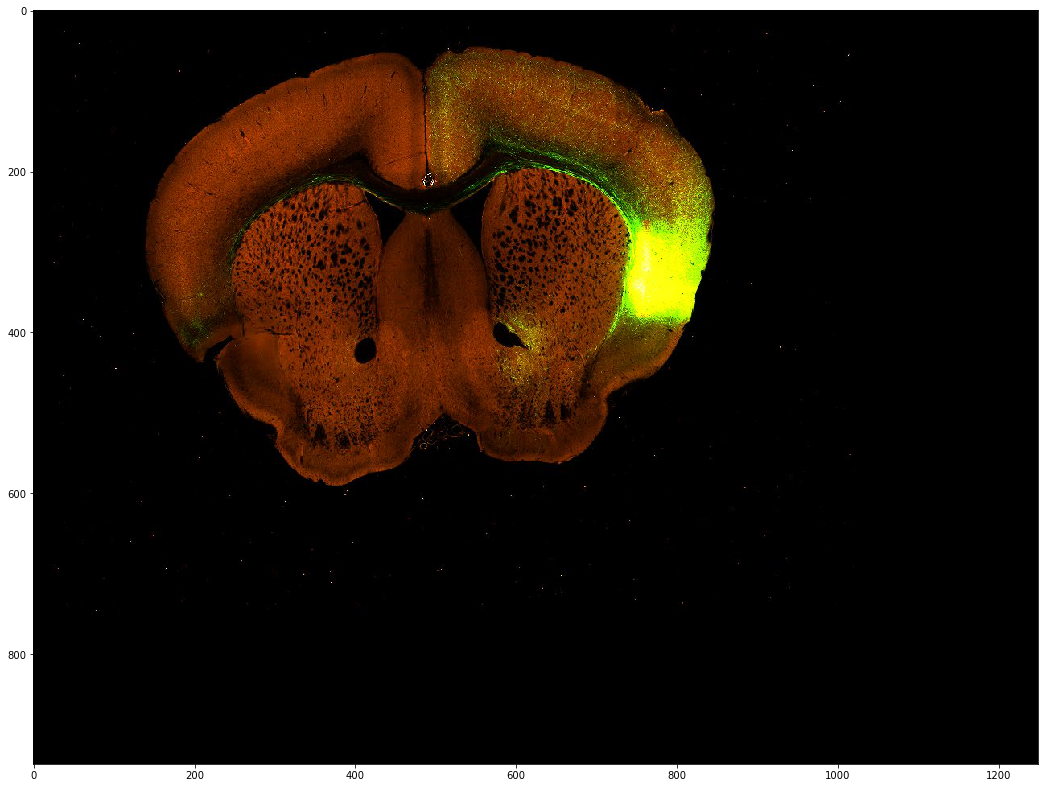

In [355]:
# projection segmentation (fluorescence)
# serial two-photon tomography (image complete)

import numpy as np
from allensdk.api.queries.image_download_api import ImageDownloadApi
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd

def verify_image(file_path, figsize=(18, 22)):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    
image_api = ImageDownloadApi()

section_image_id = 299783875 # /!\ c'est l'id d'UNE image parmi le thumbnails de 299783689
file_path = '/Users/mahdi/stage-2022-mahdi/src/image-marron.jpg'
downsample = 5

ranges = image_api.get_section_image_ranges([section_image_id])[0]

image_api.download_projection_image(section_image_id, file_path, downsample=downsample, range=ranges)

verify_image(file_path)
test = np.lo

# Telecharger toutes les images 

## Image + fluorescence

In [349]:
id = 288169135 #id de l'experience
downsample=5

section_image_directory = '/Users/mahdi/stage-2022-mahdi/src/288169135'
format_str = '.jpg'

section_images = image_api.section_image_query(section_data_set_id)
section_image_ids = [si['id'] for si in section_images]

print(len(section_image_ids))

140


In [350]:
import logging
import os
from allensdk.config.manifest import Manifest

# The following line will temporarily disable the download logger.
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = True

for section_image_id in section_image_ids:
    
    file_name = str(section_image_id) + format_str
    file_path = os.path.join(section_image_directory, file_name)
    
    Manifest.safe_make_parent_dirs(file_path)

    image_ranges = image_api.get_section_image_ranges([section_image_id])[0]
    image_api.download_section_image(section_image_id, file_path=file_path, downsample=downsample, range=image_ranges)
    
# re-enable the logger
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = False

#### 3m11s d'execution ###

## Projection (fluorescence)

In [1]:
import numpy as np
from allensdk.api.queries.image_download_api import ImageDownloadApi
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd

def verify_image(file_path, figsize=(18, 22)):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    
image_api = ImageDownloadApi()

id = 288169135 #id de l'experience
downsample=5

projection_image_directory = '/Users/mahdi/stage-2022-mahdi/images/288169135_proj_density_'
format_str = '.jpg'

projection_images = image_api.section_image_query(id)
ids = [pi['id'] for pi in projection_images]

print(len(ids))

140


In [354]:
import logging
import os
from allensdk.config.manifest import Manifest

# The following line will temporarily disable the download logger.
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = True

for projection_image_id in ids:
    
    file_name = str(projection_image_id) + format_str
    file_path = os.path.join(projection_image_directory, file_name)
    
    Manifest.safe_make_parent_dirs(file_path)

    image_api.download_projection_image(
        projection_image_id, 
        file_path=file_path, 
        downsample=downsample, 
        projection=True)
    
# re-enable the logger
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = False

#### 3m11s d'execution ###

In [ ]:
file_names = os.listdir(projection_image_directory)
print(len(file_names))

140


In [376]:
from allensdk.api.queries.grid_data_api import GridDataApi
import nrrd

gda = GridDataApi()

projection_grid_data = gda.download_projection_grid_data(299783689)


file_name = '/Users/mahdi/stage-2022-mahdi/src/299783689.nrrd'
data_array, metadata = nrrd.read(filename=file_name)
print(metadata)



2022-04-29 12:49:18,795 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/299783689


OrderedDict([('type', 'float'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([132,  80, 114])), ('space directions', array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])


# .nrrd to .nii

In [1]:
import os
import glob
import nrrd
import nibabel as nib
import numpy as np
import pandas as pd

directory = '/Users/mahdi/stage-2022-mahdi/src'

# load .nrrd
template_data_array, template_metadata = nrrd.read('/Users/mahdi/stage-2022-mahdi/src/average_template_25.nrrd')
projection_data_array, projection_metadata= nrrd.read('/Users/mahdi/stage-2022-mahdi/src/299783689.nrrd')

# visualise data
print(template_metadata,projection_metadata) 


OrderedDict([('type', 'unsigned short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))]) OrderedDict([('type', 'float'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([132,  80, 114])), ('space directions', array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])


### template with a header copy

In [ ]:
# load reference .nii.gz
reference_exemple = '/Users/mahdi/stage-2022-mahdi/src/AVGT.nii.gz'
reference_img = nib.load(reference_exemple)

# copy header
reference_header = header=reference_img.header.copy()
print(reference_header)

# data from the .nrrd file
data_from_nrrd = template_data_array

# new image
new_img = nib.nifti1.Nifti1Image(data_from_nrrd, None, header=reference_header)
nib.save(new_img, os.path.join(directory, 'template_from_AVGT.nii.gz')) 
print(new_img.header)

### template 

In [2]:
# save .nii
    # template
template_img = nib.Nifti1Image(template_data_array, np.eye(4))
nib.save(template_img, os.path.join(directory, 'template.nii.gz'))

### projection from grid-data 

In [3]:
  # projection
projection_img = nib.Nifti1Image(projection_data_array, np.eye(4))
nib.save(projection_img, os.path.join(directory, 'projection.nii.gz'))

### projection from connectivity api

In [4]:
api_projection_nrrd = '/Users/mahdi/stage-2022-mahdi/src/test_projection_density'
api_projection_data_array, api_projection_metadata = nrrd.read(filename=api_projection_nrrd)

api_projection_img = nib.Nifti1Image(api_projection_data_array, np.eye(4))
nib.save(api_projection_img, os.path.join(directory, 'api_projection.nii.gz'))

# Reorient .nii

In [53]:
img = nib.load('/Users/mahdi/stage-2022-mahdi/src/template_copy.nii.gz')
print(nib.aff2axcodes(img.affine))
print(img.affine)

('R', 'A', 'S')
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [53]:
import os
import nibabel as nib
import numpy as np

# Creating a identity matrix
I4 = np.eye(4)
# Set the resolution to 70
I4 = I4 * 0.07

print(I4)

# Creating transformation matrix
txyz = np.array([-5.675, -8.79448, -8.450335, 0])
I4[:,3] = I4[:,3] + txyz

print(I4)


[[0.07 0.   0.   0.  ]
 [0.   0.07 0.   0.  ]
 [0.   0.   0.07 0.  ]
 [0.   0.   0.   0.07]]
[[ 0.07      0.        0.       -5.675   ]
 [ 0.        0.07      0.       -8.79448 ]
 [ 0.        0.        0.07     -8.450335]
 [ 0.        0.        0.        0.07    ]]


In [36]:
from pathlib import Path

id, ib, it = 111, 000, 333
dir = Path(f'crossing_research')
subdir = Path(dir / f'{id}_{it}_{ib}_crossing_research')
dir.mkdir(exist_ok=True, parents=True)
subdir.mkdir(exist_ok=True, parents=True)
nrrd_blue = dir / subdir / f"file.txt"
with open(nrrd_blue, "w") as file:
    file.write("lol")

FileNotFoundError: [Errno 2] No such file or directory: 'crossing_research/crossing_research/111_333_0_crossing_research/file.txt'